In [1]:
!pwd
!which python

/home/wwc/bem_git/bem/examples/SimpleTrap
/home/wwc/anaconda3/envs/ele35/bin/python


In [2]:
import sys
import logging, os
import numpy as np
# To import pyface.py is just for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# that is incompatible with "pyside" in package "mayavi". wwc
import pyface.qt    
import matplotlib.pyplot as plt
from multiprocessing import Pool    # parallel computation.

sys.path.append('../../')   # add path of package "bem" to search list. wwc
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list. wwc

In [3]:
prefix = "SE_20180824_0d1_0d1_8"  # SE_cos_m8
suffix = ""

In [4]:
# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 DC6 RF".split():    #  DC2 DC3 DC4 DC5 RF
    # r = Result.from_vtk(prefix, name)
    # r after from_result(): e ~ obj = cls(origin=origin, spacing=spacing, data=pot). 
    # A vtk file after from_vtk(): obj = cls(origin=origin, spacing=spacing, data=pot). 
    # So after using from_vtk() we jump over r and get to e.
    e = GridElectrode.from_vtk("%s%s_"%(prefix,suffix)+name+".vtk",maxderiv=4)    # from_vtk() is classmethod()
    e.name = name
    s.append(e)    # class System(list), System inherits list method "append" wwc
# For why instance s is subscriptable (can use []), this relates to "__getitem__() method" in System() class.  wwc
print(s["RF"],s["RF"].rf)
print(e,e.rf)

<electrode.electrode.GridElectrode object at 0x7ff62c64c4c0> 0.0
<electrode.electrode.GridElectrode object at 0x7ff62c64c4c0> 0.0


In [5]:
import scipy.constants as ct
l = 40e-6 # length scale
u = 103.25 # peak rf voltage
o = 87e6*2*np.pi # rf frequency
m = 24.3*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge

V5 = 5.0
DCvol = {"DC1":0.320*V5,"DC2":0.718*V5,"DC3":0.738*V5,"DC4":-0.898*V5,"DC5":V5,"DC6":0.0*V5}
for edc in DCvol:
    s[edc].dc = DCvol[edc]
    print(edc,s[edc].dc,"V")
# Pay attention to s.rf_scale(m,q,l,o) pesudo potential coefficient! See blakestad2010 Eq.(5.2).  wwc
s["RF"].rf = s.rf_scale(m,q,l,o)*u   # s["RF"] == e, create attribute e.rf  wwc
# s["RF"].rf = u*np.sqrt(q/m)/(2*l*o)
print("RF",s["RF"].rf,"V")

xi = (0.1, 0.8, 0.8)
#x0 = s.minimum(xi)
x0 = np.array([0.0,1.025,0.89])
print("\nx0",x0)
print("minimum offset: %s\n"%(x0-xi))
# analyze_static(x, axis=(0, 1, 2), m=ct.atomic_mass, q=ct.elementary_charge, l=100e-6, o=2*np.pi*1e6, ions=1, log=None):
for line in s.analyze_static(x0, m=m, q=q, l=l, o=o):      # u=50., # u is V rf peak voltage, but it causes error.
    print(line)

DC4 -4.49 V
DC1 1.6 V
DC3 3.69 V
DC2 3.59 V
DC6 0.0 V
DC5 5.0 V
RF 4.70466240941 V

x0 [ 0.     1.025  0.89 ]
minimum offset: [-0.1    0.225  0.09 ]

parameters:
 f=87 MHz, m=24.3 amu, q=1 qe, l=40 µm, scale=0.0456 V'/V_SI
coordinates:
 analyze point: [ 0.     1.025  0.89 ]
               ([  0.   41.   35.6] µm)
 minimum is at offset: [ 0.  0.  0.]
                      ([ 0.  0.  0.] µm)
potential:
 dc electrical: 0.855 eV
 rf pseudo: 0.00381 eV
 saddle offset: [-0.42808529  0.19661377  0.80059743]
               ([-17.12341143   7.86455079  32.02389711] µm)
 saddle height: 0.207 eV
force:
 dc electrical: [ 0.05154732 -0.01623194 -0.06433946] eV/l
               ([ 1288.6830625  -405.7984125 -1608.4866   ] eV/m)
 rf pseudo: [-0.00103078  0.06621732  0.20444553] eV/l
           ([  -25.76940432  1655.43299528  5111.13832051] eV/m)
 total: [ 0.05051655  0.04998538  0.14010607] eV/l
           ([ 1262.91365818  1249.63458278  3502.65172051] eV/m)
modes:
 pp+dc normal curvatures: [ 0.121

In [6]:

x0=np.array([0.,1.1,1.2])
Ef=-s.time_potential(x=x0,t=0,derivative=1)[0]
dv=Ef*q/m*dt
dx=1/2*(Ef*q/m)*dt**2
print("Ef",Ef)
print("dx",dx,"dv",dv)

Vf1=s.time_potential(x=(0.0,1.2,1.3),t=0,derivative=0)[0]
Vf2=s.time_potential(x=(0.2,1.2,1.3),t=0,derivative=0)[0]
print(Vf1,Vf2,-(Vf2-Vf1)/0.2)

Ef [-0.04315507 -0.28780573  0.10019115]
dx [ -8.56755373e-06  -5.71379256e-05   1.98908987e-05] dv [ -1.71351075 -11.42758512   3.97817974]
[ 3.05424734] [ 3.06335718] [-0.04554917]


In [11]:
x0=np.array([0.,1.1,1.2])
trtoy=s.trajectory_toy(x0=x0,v0=(0.,0.,0.),qoverm=q/m,axis=(0,1,2),dt=dt,nsteps=1)
for i in range(3):
    a=next(trtoy)
    print(*a)
    print("dx",a[1]-x0)

1e-05 [ -8.56755373e-06   1.09994286e+00   1.20001989e+00] [ -1.71351075 -11.42758512   3.97817974]
dx [ -8.56755373e-06  -5.71379256e-05   1.98908987e-05]
2e-05 [ -3.42709384e-05   1.09977145e+00   1.20007957e+00] [ -3.42716619 -22.85525306   7.95740917]
dx [ -3.42709384e-05  -2.28552116e-04   7.95688433e-05]
3e-05 [ -7.71130476e-05   1.09948576e+00   1.20017905e+00] [ -5.14125565 -34.28317001  11.93978696]
dx [ -7.71130476e-05  -5.14244232e-04   1.79054824e-04]


In [13]:
dt=np.float128(1e-5)
x0=np.array([0.,1.1,1.2])
tr=s.trajectory(x0=x0,v0=(0.,0.,0.),qoverm=q/m,axis=(0,1,2),dt=dt,nsteps=1)
for i in range(3):
    a=next(tr)
    print(*a)
    print("dx",a[1]-x0)

1e-05 [ -8.56767431e-06   1.09994286e+00   1.20001989e+00] [ -1.71355898 -11.42761272   3.97852965]
dx [ -8.56767431e-06  -5.71379946e-05   1.98917735e-05]
2e-05 [ -3.42721441e-05   1.09977145e+00   1.20007958e+00] [ -3.42740732 -22.85539133   7.95915847]
dx [ -3.42721441e-05  -2.28552807e-04   7.95775904e-05]
3e-05 [ -7.71177496e-05   1.09948575e+00   1.20017909e+00] [ -5.1418343  -34.28350293  11.94398434]
dx [ -7.71177496e-05  -5.14246931e-04   1.79088933e-04]


In [8]:
# # To understand the data structure of GridElectrode.data.  wwc
# print(e.origin, e.spacing)
# print(len(e.data),type(e.data))  # [pot_array,field_array,2nd_pot_array,3rd_pot_array], 0~3,4th derivative order.
# print(type(e.data[0]),type(e.data[1]))  # All list elements are ndarray.
# print(e.data[0].shape,e.data[1].shape)    # (nx,ny,nz,components)
# print(e.data[0])    # potential
# # [[[[p(x0,y0,z0)],
# #    [p(x0,y0,z1)],
# #    [p(x0,y0,z2)]],
# #    
# #   [[p(x0,y1,z0)],
# #    [p(x0,y1,z1)],
# #    [p(x0,y1,z2)]],     
# #
# #   ]]

In [7]:
# This is from electrode turtorial.ipynb  wwc
# import scipy.constants as ct
# l = 30e-6 # µm length scale
# u = 20. # V rf peak voltage
# m = 25*ct.atomic_mass # ion mass
# q = 1*ct.elementary_charge # ion charge
# o = 2*np.pi*100e6 # rf frequency in rad/s
# s["RF"].rf = u*np.sqrt(q/m)/(2*l*o)
# print(s["RF"])

# x0 = s.minimum((0, 0, 1.), axis=(1, 2))

# for line in s.analyze_static(x0, axis=(1,0), m=m, q=q, l=l, o=o):
#     print(line)

In [8]:
# Test np.linalg.eigh.
# mat = np.array([[3,0,1],[0,2,0],[1,0,3]])
# print(mat)
# np.linalg.eigh(mat)

In [18]:
# x is single point coord. x will be round to neatest points so x never go beyond boundary.
xi = (0., 1.2, 1.2)
x0 = s.minimum(xi)
print("\nx0",x0)
print("minimum offset: %s\n"%(x0-xi))
#x0 = np.array([0.0,1.0,1.0])
print("potential at x0:",s.potential(x=x0,derivative=0)[0])
print("min DC1 potential:",np.amin(s["DC1"].data[0]))
print()

print(s.potential(x0, 2)[0])
eigen = np.linalg.eigh(s.potential(x0, 2)[0])
print(eigen)
s.modes(x0)

ValueError: failed, 0, Warning: Desired error not necessarily achieved due to precision loss.,      fun: 0.8468544327503894
     jac: array([-0.00080828, -0.00363414, -0.00231351])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 32
    nhev: 8
     nit: 7
    njev: 27
  status: 2
 success: False
       x: array([-0.36343205,  1.01224497,  0.86479654])

In [21]:
x0=np.array([0.,1.1,1.2])
trj=[x0]
tr=s.trajectory(x0=x0,v0=(0.,200.,100.),qoverm=q/m,axis=(0,1,2),dt=dt,nsteps=10,pseudo=1)
for i in range(30):
    a=next(tr)
    trj.append(a[1])
    #print(*a)
    #print("dx",a[1]-x0)

/home/wwc/anaconda3/envs/ele35/lib/python3.5/site-packages/scipy/integrate/_ivp/common.py:32: UserWarning: The following arguments have no effect for a chosen solver: `pseudo`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


10 -0.025
[slice(-0.52500000000000002, 0.47499999999999998, 21j), slice(0.27500000000000002, 1.9750000000000001, 35j), slice(0.47499999999999998, 2.4750000000000001, 41j)]
(3, 35, 41)
(35, 41)

minimum: [ 0.     1.025  0.886]
minimum offset: [-0.1    0.225  0.086]

saddle: [-0.38103746  1.20260519  1.66388321]
saddle offset: [-0.38103746  0.17760519  0.77788321]
saddle height: [ 0.20790916]


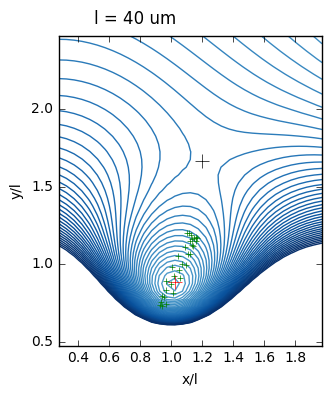

In [22]:
start = np.array([-0.5,0.3,0.5])
end = np.array([0.5,2.0,2.5])
nextra = 1
#print(1,start,end)
ngd_s = np.floor((start-s["RF"].origin)/s["RF"].spacing).astype(int)
ngd_e = np.floor((end-s["RF"].origin)/s["RF"].spacing).astype(int)
#print(2,ngd_s,ngd_e)
start = np.round(ngd_s*s["RF"].spacing+s["RF"].origin,5)    # round 5 digits.  wwc
end = np.round(ngd_e*s["RF"].spacing+s["RF"].origin,5)
#print(3,start,end)
ngd = np.floor((end-start)/s["RF"].spacing).astype(int)

xpl = x0[0]
xyz = [np.linspace(st,en,(ng+1)*nextra)     # xyz is the potential coords
       for st,en,ng in zip(start,end,ngd)]
xpln = np.rint((xpl-start[0])/s["RF"].spacing[0]).astype(int)
print(xpln,xyz[0][xpln])    # xyz[0][xpln] is the nearest grid point near xpl.
slc = [slice(st,en,1j*(ng+1)*nextra) 
       for st,en,ng in zip(start,end,ngd)]    # mgrid slices
print(slc)
xyzg = np.mgrid[slc][:,xpln]    # yz plane
#yzg = np.mgrid[[slc[1],slc[2]]]
print(xyzg.shape)

pot = []
for y in xyz[1]:  # [::-1]
    # s.potential(x=(xpl,y,z),derivative=0) returns a shape (1,) array. array[pot(xpl,y,z)]. So add a [0].  wwc
    potz = np.array([s.potential(x=(xpl,y,z),derivative=0)[0] for z in xyz[2] ])          
    pot.append(potz)
pot = np.array(pot)
print(pot.shape)

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyzg[1], xyzg[2], pot, levels=np.linspace(0, 1.5, 100), cmap=plt.cm.Blues, figsize=(14,12))

#xi = (0., 1.1, 1.1)
#x01 = s.minimum(xi)
x0 = np.array([0.,1.025,0.886])
print("\nminimum:",x0)
print("minimum offset: %s"%(x0-xi))
xs,xsp = s.saddle(x0+1e0*x0[2])
p_dc = s.electrical_potential(x0,"dc",0)[0]
p_rf = s.pseudo_potential(x0,0)[0]
print("\nsaddle:",xs)
print("saddle offset: %s"%(xs-x0))
print("saddle height:",xsp-(p_dc+p_rf))
ax.plot(x0[1],x0[2],'r+',markersize=10)
ax.plot(xs[1],xs[2],'k+',markersize=10)

# start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(0.5,3, 0.5))
ax.set_xlabel("x/l",fontsize=10)
ax.set_ylabel("y/l",fontsize=10)
ax.text(0.5,2.55,"l = %d um"%(l/1e-6),fontsize=12)
fig.set_size_inches(4, 4)
fig.set_dpi(100)

for pt in trj:
    ax.plot(pt[1],pt[2],'g+',markersize=5)

In [ ]:
#ar = [np.arange(st,en,spn) for st,en,spn in zip(start,end,s["RF"].spacing/nextra)]
#print(ar)
# ngd = np.floor((end-start)/s["RF"].spacing).astype(int)*nextra

# pot = np.array([s.potential(x=(xpl,ar[1],ar[2]),derivative=0)])

In [ ]:
s["DC1"].data[0].shape
s1 = s["DC1"].data[0].reshape((62,62,62))
s1.shape

In [9]:
print(s["RF"].origin)
print(s["RF"].spacing)

start = np.array([-0.5,0.5,0.5])
end = np.array([0.5,2.0,1.5])
print(1,start,end)
ngd_s = np.floor((start-s["RF"].origin)/s["RF"].spacing).astype(int)
ngd_e = np.floor((end-s["RF"].origin)/s["RF"].spacing).astype(int)
print(2,ngd_s,ngd_e)
start = np.round(ngd_s*s["RF"].spacing+s["RF"].origin,8)    # round 8 digits.  wwc
end = np.round(ngd_e*s["RF"].spacing+s["RF"].origin,8)
print(3,start,end)

ngd = np.floor((end-start)/s["RF"].spacing).astype(int)
slc = [slice(st,en,1j*(ng+1)) 
       for st,en,ng in zip(start,end,ngd)]
print(slc)
#np.mgrid[slc]

[-1.525 -0.525 -0.525]
[0.05 0.05 0.05]
1 [-0.5  0.5  0.5] [0.5 2.  1.5]
2 [20 20 20] [40 50 40]
3 [-0.525  0.475  0.475] [0.475 1.975 1.475]
[slice(-0.525, 0.475, 21j), slice(0.475, 1.975, 31j), slice(0.475, 1.475, 21j)]


In [10]:
n = 50
xyz = np.mgrid[-d:d:1j*n, -d:d:1j*n, h:h+1]
fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect="equal"))
pot = shaped(s.potential)(xyz)
v = np.arange(-15, 3)
x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
ax[0].contour(x, y, np.log2(p), v, cmap=plt.cm.hot)

(xs1, ps1), (xs0, ps0) = s.saddle(x0+1e-2), s.saddle([0, 0, .8])
print("main saddle:", xs0, ps0)
xyz = np.mgrid[-d:d:1j*n, 0:1, .7*h:3*h:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
ax[1].contour(x, z, np.log2(p), v, cmap=plt.cm.hot)
ax[1].contour(x, z, np.log2(p), np.log2((ps1, ps0)), color="black")

NameError: name 'd' is not defined